# Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta

from config import Config
config=Config()
# InstaBot, 
from footkit import Preprocess, Parser, Validation, Calculation, OddsParser, PlotPredict, FeatureSelector
from footkit.utils import report_validation

from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
# making the workspace wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# more information in the tables
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',150)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

import asyncio

# Парсер событий из UnderStat.com, читаем через api
* сбор данных, агрегация, генерация признаков
* если нужно обновить update_data = True

In [2]:
parser = Parser(Config)
df, teams_df = await parser.get_parse_data(update_data=True, resaved_data=True)
# asyncio.get_event_loop().run_until_complete(parser.get_parse_data(update_data=False, resaved_data=True))
print('Прогнозируем:', parser.predict_targets)

preprocess=Preprocess(Config, df, teams_df)
teams_df=preprocess.get_teams_df()

df, engineering_features = preprocess.create_features()
df_targets, targets = preprocess.get_target_on_df_eng('FTHG', 'FTAG')

Прогнозируем: ['W', 'L', '1X', '2X', 'Total Less 1.5', 'Total Less 2.5', 'Total Less 3.5', 'Total More 1.5', 'Total More 2.5', 'Total More 3.5']
до обработки Shape==1:  True
после обработки Shape==1:  True


In [15]:
df.head()

,DateTime,LeagueName,Season,HomeTeam,HomeShortTeam,HomeTeamId,HomeTeam_xG,AwayTeam,AwayShortTeam,AwayTeamId,AwayTeam_xG,WinProba,DrawProba,LoseProba,FTHG,FTAG,IsResult,Date,HomeTeamName,HomeWinProba,HomeDrawProba,HomeLoseProba,h_a,HomexG,HomexGA,HomenpxG,HomenpxGA,Homeppda_att,Homeppda_def,Homeppda_allowed_att,Homeppda_allowed_def,Homedeep,Homedeep_allowed,Homescored,Homemissed,Homexpts,result,Homewins,Homedraws,Homeloses,Homepts,HomenpxGD,RoundEvent,HomeChillDays,HomeShift1scored,HomeCum1scored,HomeShift2scored,HomeCum2scored,HomeShift3scored,HomeCum3scored,HomeDeltaShiftscored,HomeDeltaCumscored,HomeCumscored,HomeShift1missed,HomeCum1missed,HomeShift2missed,HomeCum2missed,HomeShift3missed,HomeCum3missed,HomeDeltaShiftmissed,HomeDeltaCummissed,HomeCummissed,HomeShift1pts,HomeCum1pts,HomeShift2pts,HomeCum2pts,HomeShift3pts,HomeCum3pts,HomeDeltaShiftpts,HomeDeltaCumpts,HomeCumpts,HomeShift1xG,HomeCum1xG,HomeShift2xG,HomeCum2xG,...,AwayAvgmissed5_PLACE,AwayAvgpts3,AwayAvgpts5,AwayAvgpts3_PLACE,AwayAvgpts5_PLACE,AwayAvgxG3,AwayAvgxG5,AwayAvgxG3_PLACE,AwayAvgxG5_PLACE,AwayAvgxGA3,AwayAvgxGA5,AwayAvgxGA3_PLACE,AwayAvgxGA5_PLACE,AwayAvgnpxG3,AwayAvgnpxG5,AwayAvgnpxG3_PLACE,AwayAvgnpxG5_PLACE,AwayAvgnpxGA3,AwayAvgnpxGA5,AwayAvgnpxGA3_PLACE,AwayAvgnpxGA5_PLACE,AwayAvgppda_att3,AwayAvgppda_att5,AwayAvgppda_att3_PLACE,AwayAvgppda_att5_PLACE,AwayAvgppda_def3,AwayAvgppda_def5,AwayAvgppda_def3_PLACE,AwayAvgppda_def5_PLACE,AwayAvgppda_allowed_att3,AwayAvgppda_allowed_att5,AwayAvgppda_allowed_att3_PLACE,AwayAvgppda_allowed_att5_PLACE,AwayAvgppda_allowed_def3,AwayAvgppda_allowed_def5,AwayAvgppda_allowed_def3_PLACE,AwayAvgppda_allowed_def5_PLACE,AwayAvgdeep3,AwayAvgdeep5,AwayAvgdeep3_PLACE,AwayAvgdeep5_PLACE,AwayAvgdeep_allowed3,AwayAvgdeep_allowed5,AwayAvgdeep_allowed3_PLACE,AwayAvgdeep_allowed5_PLACE,AwayAvgxpts3,AwayAvgxpts5,AwayAvgxpts3_PLACE,AwayAvgxpts5_PLACE,AwayAvgwins3,AwayAvgwins5,AwayAvgwins3_PLACE,AwayAvgwins5_PLACE,AwayAvgdraws3,AwayAvgdraws5,AwayAvgdraws3_PLACE,AwayAvgdraws5_PLACE,AwayAvgloses3,AwayAvgloses5,AwayAvgloses3_PLACE,AwayAvgloses5_PLACE,AwayAvgnpxGD3,AwayAvgnpxGD5,AwayAvgnpxGD3_PLACE,AwayAvgnpxGD5_PLACE,AwayAvgChillDays3,AwayAvgChillDays5,AwayAvgChillDays3_PLACE,AwayAvgChillDays5_PLACE,Month,Year,Week,Day,Dayofweek,y_pred
IdMatch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
461,2016-08-13 15:30:00,epl,2016,Hull,HUL,91,0.740,Leicester,LEI,75,2.456,0.054,0.125,0.822,2.000,1.000,True,2016-08-13,Hull,0.054,0.125,0.822,h,0.740,2.456,0.740,1.695,268.000,15.000,282.000,25.000,0.000,5.000,2.000,1.000,0.286,w,1.000,0.000,0.000,3.000,-0.955,1,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2016,32,13,5,NaN
462,2016-08-13 18:00:00,epl,2016,Crystal Palace,CRY,78,0.990,West Bromwich Albion,WBA,76,0.685,0.430,0.336,0.235,0.000,1.000,True,2016-08-13,Crystal Palace,0.430,0.336,0.235,h,0.990,0.685,0.990,0.685,98.000,23.000,184.000,26.000,4.000,5.000,0.000,1.000,1.624,l,0.000,0.000,1.000,0.000,0.305,1,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2016,32,13,5,NaN
463,2016-08-13 18:00:00,epl,2016,Eve

In [16]:
df.query('HomeTeam == "FC Krasnodar" or AwayTeam == "FC Krasnodar"')

,DateTime,LeagueName,Season,HomeTeam,HomeShortTeam,HomeTeamId,HomeTeam_xG,AwayTeam,AwayShortTeam,AwayTeamId,AwayTeam_xG,WinProba,DrawProba,LoseProba,FTHG,FTAG,IsResult,Date,HomeTeamName,HomeWinProba,HomeDrawProba,HomeLoseProba,h_a,HomexG,HomexGA,HomenpxG,HomenpxGA,Homeppda_att,Homeppda_def,Homeppda_allowed_att,Homeppda_allowed_def,Homedeep,Homedeep_allowed,Homescored,Homemissed,Homexpts,result,Homewins,Homedraws,Homeloses,Homepts,HomenpxGD,RoundEvent,HomeChillDays,HomeShift1scored,HomeCum1scored,HomeShift2scored,HomeCum2scored,HomeShift3scored,HomeCum3scored,HomeDeltaShiftscored,HomeDeltaCumscored,HomeCumscored,HomeShift1missed,HomeCum1missed,HomeShift2missed,HomeCum2missed,HomeShift3missed,HomeCum3missed,HomeDeltaShiftmissed,HomeDeltaCummissed,HomeCummissed,HomeShift1pts,HomeCum1pts,HomeShift2pts,HomeCum2pts,HomeShift3pts,HomeCum3pts,HomeDeltaShiftpts,HomeDeltaCumpts,HomeCumpts,HomeShift1xG,HomeCum1xG,HomeShift2xG,HomeCum2xG,...,AwayAvgmissed5_PLACE,AwayAvgpts3,AwayAvgpts5,AwayAvgpts3_PLACE,AwayAvgpts5_PLACE,AwayAvgxG3,AwayAvgxG5,AwayAvgxG3_PLACE,AwayAvgxG5_PLACE,AwayAvgxGA3,AwayAvgxGA5,AwayAvgxGA3_PLACE,AwayAvgxGA5_PLACE,AwayAvgnpxG3,AwayAvgnpxG5,AwayAvgnpxG3_PLACE,AwayAvgnpxG5_PLACE,AwayAvgnpxGA3,AwayAvgnpxGA5,AwayAvgnpxGA3_PLACE,AwayAvgnpxGA5_PLACE,AwayAvgppda_att3,AwayAvgppda_att5,AwayAvgppda_att3_PLACE,AwayAvgppda_att5_PLACE,AwayAvgppda_def3,AwayAvgppda_def5,AwayAvgppda_def3_PLACE,AwayAvgppda_def5_PLACE,AwayAvgppda_allowed_att3,AwayAvgppda_allowed_att5,AwayAvgppda_allowed_att3_PLACE,AwayAvgppda_allowed_att5_PLACE,AwayAvgppda_allowed_def3,AwayAvgppda_allowed_def5,AwayAvgppda_allowed_def3_PLACE,AwayAvgppda_allowed_def5_PLACE,AwayAvgdeep3,AwayAvgdeep5,AwayAvgdeep3_PLACE,AwayAvgdeep5_PLACE,AwayAvgdeep_allowed3,AwayAvgdeep_allowed5,AwayAvgdeep_allowed3_PLACE,AwayAvgdeep_allowed5_PLACE,AwayAvgxpts3,AwayAvgxpts5,AwayAvgxpts3_PLACE,AwayAvgxpts5_PLACE,AwayAvgwins3,AwayAvgwins5,AwayAvgwins3_PLACE,AwayAvgwins5_PLACE,AwayAvgdraws3,AwayAvgdraws5,AwayAvgdraws3_PLACE,AwayAvgdraws5_PLACE,AwayAvgloses3,AwayAvgloses5,AwayAvgloses3_PLACE,AwayAvgloses5_PLACE,AwayAvgnpxGD3,AwayAvgnpxGD5,AwayAvgnpxGD3_PLACE,AwayAvgnpxGD5_PLACE,AwayAvgChillDays3,AwayAvgChillDays5,AwayAvgChillDays3_PLACE,AwayAvgChillDays5_PLACE,Month,Year,Week,Day,Dayofweek,y_pred
IdMatch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2596,2016-08-01 20:30:00,rfpl,2016,FC Krasnodar,KRA,196,1.986,Tom Tomsk,TOM,201,0.158,0.878,0.108,0.014,3.000,0.000,True,2016-08-01,FC Krasnodar,0.878,0.108,0.014,h,1.986,0.158,1.986,0.158,134.000,27.000,344.000,17.000,12.000,2.000,3.000,0.000,2.742,w,1.000,0.000,0.000,3.000,1.827,1,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2016,31,1,0,NaN
2603,2016-08-08 20:30:00,rfpl,2016,FC Krasnodar,KRA,196,1.782,FK Akhmat,AKH,188,0.381,0.820,0.147,0.033,4.000,0.000,True,2016-08-08,FC Krasnodar,0.820,0.147,0.033,h,1.782,0.381,0.923,0.381,239.000,15.000,313.000,24.000,9.000,5.000,4.000,0.000,2.607,w,1.000,0.000,0.000,3.000,0.541,2,7.000,3.000,3.000,0.000,0.000,0.000,0.000,1.500,1.500,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,1.500,1.500,3.000,1.986,1.986,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2016,32,8,0,NaN
2607,2016-08-13 19:00:00,r

In [32]:
team_a = 'FC Krasnodar'
team_b = 'Lokomotiv Moscow'

# df.query('(HomeTeam in [@team_a, @team_b]) or (AwayTeam in [@team_a, @team_b])')
df.query('(HomeTeam == @team_a and AwayTeam == @team_b) or (HomeTeam == @team_b and AwayTeam == @team_a)')

,DateTime,LeagueName,Season,HomeTeam,HomeShortTeam,HomeTeamId,HomeTeam_xG,AwayTeam,AwayShortTeam,AwayTeamId,AwayTeam_xG,WinProba,DrawProba,LoseProba,FTHG,FTAG,IsResult,Date,HomeTeamName,HomeWinProba,HomeDrawProba,HomeLoseProba,h_a,HomexG,HomexGA,HomenpxG,HomenpxGA,Homeppda_att,Homeppda_def,Homeppda_allowed_att,Homeppda_allowed_def,Homedeep,Homedeep_allowed,Homescored,Homemissed,Homexpts,result,Homewins,Homedraws,Homeloses,Homepts,HomenpxGD,RoundEvent,HomeChillDays,HomeShift1scored,HomeCum1scored,HomeShift2scored,HomeCum2scored,HomeShift3scored,HomeCum3scored,HomeDeltaShiftscored,HomeDeltaCumscored,HomeCumscored,HomeShift1missed,HomeCum1missed,HomeShift2missed,HomeCum2missed,HomeShift3missed,HomeCum3missed,HomeDeltaShiftmissed,HomeDeltaCummissed,HomeCummissed,HomeShift1pts,HomeCum1pts,HomeShift2pts,HomeCum2pts,HomeShift3pts,HomeCum3pts,HomeDeltaShiftpts,HomeDeltaCumpts,HomeCumpts,HomeShift1xG,HomeCum1xG,HomeShift2xG,HomeCum2xG,...,AwayAvgmissed5_PLACE,AwayAvgpts3,AwayAvgpts5,AwayAvgpts3_PLACE,AwayAvgpts5_PLACE,AwayAvgxG3,AwayAvgxG5,AwayAvgxG3_PLACE,AwayAvgxG5_PLACE,AwayAvgxGA3,AwayAvgxGA5,AwayAvgxGA3_PLACE,AwayAvgxGA5_PLACE,AwayAvgnpxG3,AwayAvgnpxG5,AwayAvgnpxG3_PLACE,AwayAvgnpxG5_PLACE,AwayAvgnpxGA3,AwayAvgnpxGA5,AwayAvgnpxGA3_PLACE,AwayAvgnpxGA5_PLACE,AwayAvgppda_att3,AwayAvgppda_att5,AwayAvgppda_att3_PLACE,AwayAvgppda_att5_PLACE,AwayAvgppda_def3,AwayAvgppda_def5,AwayAvgppda_def3_PLACE,AwayAvgppda_def5_PLACE,AwayAvgppda_allowed_att3,AwayAvgppda_allowed_att5,AwayAvgppda_allowed_att3_PLACE,AwayAvgppda_allowed_att5_PLACE,AwayAvgppda_allowed_def3,AwayAvgppda_allowed_def5,AwayAvgppda_allowed_def3_PLACE,AwayAvgppda_allowed_def5_PLACE,AwayAvgdeep3,AwayAvgdeep5,AwayAvgdeep3_PLACE,AwayAvgdeep5_PLACE,AwayAvgdeep_allowed3,AwayAvgdeep_allowed5,AwayAvgdeep_allowed3_PLACE,AwayAvgdeep_allowed5_PLACE,AwayAvgxpts3,AwayAvgxpts5,AwayAvgxpts3_PLACE,AwayAvgxpts5_PLACE,AwayAvgwins3,AwayAvgwins5,AwayAvgwins3_PLACE,AwayAvgwins5_PLACE,AwayAvgdraws3,AwayAvgdraws5,AwayAvgdraws3_PLACE,AwayAvgdraws5_PLACE,AwayAvgloses3,AwayAvgloses5,AwayAvgloses3_PLACE,AwayAvgloses5_PLACE,AwayAvgnpxGD3,AwayAvgnpxGD5,AwayAvgnpxGD3_PLACE,AwayAvgnpxGD5_PLACE,AwayAvgChillDays3,AwayAvgChillDays5,AwayAvgChillDays3_PLACE,AwayAvgChillDays5_PLACE,Month,Year,Week,Day,Dayofweek,y_pred
IdMatch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2627,2016-08-28 20:15:00,rfpl,2016,FC Krasnodar,KRA,196,1.223,Lokomotiv Moscow,LOK,192,1.563,0.231,0.329,0.440,1.000,2.000,True,2016-08-28,FC Krasnodar,0.231,0.329,0.440,h,1.223,1.563,0.469,0.809,131.000,27.000,166.000,21.000,7.000,9.000,1.000,2.000,1.023,l,0.000,0.000,1.000,0.000,-0.340,5,7.000,0.000,8.000,1.000,8.000,4.000,7.000,-2.000,0.500,8.000,2.000,3.000,1.000,1.000,0.000,0.000,1.000,1.500,3.000,0.000,7.000,1.000,7.000,3.000,6.000,-1.500,0.500,7.000,0.616,5.049,0.665,4.433,...,NaN,1.000,NaN,NaN,NaN,1.507,NaN,NaN,NaN,0.890,NaN,NaN,NaN,0.753,NaN,NaN,NaN,0.890,NaN,NaN,NaN,201.000,NaN,NaN,NaN,20.333,NaN,NaN,NaN,318.667,NaN,NaN,NaN,17.667,NaN,NaN,NaN,6.000,NaN,NaN,NaN,3.000,NaN,NaN,NaN,1.723,NaN,NaN,NaN,0.000,NaN,NaN,NaN,1.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,-0.137,NaN,NaN,NaN,7.333,NaN,NaN,NaN,8,2016,34,28,6,NaN
4310,2017-03-13 16:30:00,rfpl,2016,Lokomotiv Moscow,LOK,192,1.211,FC Krasnodar,KRA,196,1.144,0.347,0.316,0.338,1.000,2.000,True,2017-03-13,Lokomotiv Moscow,0.347,0.316,0.338,h,1.211,1.144,1.211,1.144,322.000,37.000,166.000,16.000,17.000,7.000,1.000,2.000,1.355,l,0.000,0.000,1.000,0.000,0.068,19,8.000,3.000,24.000,2.000,21.000,6.000,19.000,-1.500,2.500,24.000,0.000,13.000,0.000,13.000,1.000,13.000,-0.500,0.000,13.000,3.000,26.000,3.000,23.000,3.000,20.000,0.000,3.000,26.000,2.020,19.949,0.226,17.930,...,0.600,0.667,1.600,0.667,0.800,0.717,0.810,0.600,0.531,0.941,0.844,0.653,0.620,0.466,0.659,0.600,0.531,0.941,0.844,0.653,0.620,215.667,209.800,206.333,221.800,19.667,28.000,24.667,27.200,254.333,268.800,233.000,231.800,24.333,21.000,24.333

In [98]:
engineering_features = list(set(engineering_features) - set(['Date']))

for i in ['Awayscored', 'Awaymissed', 'Awaydraws', 'Homescored', 'Homemissed', 'Awayloses', 'Homeloses', 'Awaywins', 'AwayxGA', 'Homedraws', 'AwayxG', 'HomenpxG']:
    if i in engineering_features:
        print('loh, drop this feature', i)

In [171]:
df_targets['ResultClass'] = np.where(
    df_targets['W']==1,
    0,
    np.where(
        df_targets['D']==1,
        1,
        np.where(
            df_targets['L']==1,
            2,
            np.nan
        )
    )
)

In [279]:
df.columns

Index(['DateTime', 'LeagueName', 'Season', 'HomeTeam', 'HomeShortTeam',
       'HomeTeamId', 'HomeTeam_xG', 'AwayTeam', 'AwayShortTeam', 'AwayTeamId',
       ...
       'AwayAvgChillDays3', 'AwayAvgChillDays5', 'AwayAvgChillDays3_PLACE',
       'AwayAvgChillDays5_PLACE', 'Month', 'Year', 'Week', 'Day', 'Dayofweek',
       'y_pred'],
      dtype='object', length=685)

In [280]:
from sklearn.model_selection import train_test_split

team_a = 'FC Krasnodar'
team_b = 'Lokomotiv Moscow'
target = '2X'
df_check = df.query('LeagueName == "rfpl"')
# .query('(HomeTeam in [@team_a, @team_b]) or (AwayTeam in [@team_a, @team_b])')

X_train, X_val, y_train, y_val = train_test_split(
    df_check.query('IsResult==True')[engineering_features],
    df_targets.loc[df_check.query('IsResult==True').index][target],
    test_size=0.2,
    random_state=42
)

X_test = df_check.query('IsResult==False')[engineering_features].loc[[16283]]

In [281]:
import lightgbm as lgb

model_params = {
    # 'objective': 'multiclass',
    'objective': 'binary',
    'boosting': 'gbdt',
    'num_iterations': 200, # 00
    'learning_rate': 0.03,
    'num_leaves': 15,
    'num_threads': 7,
    'seed': 17,
    'max_depth': 5,
    'min_data_in_leaf': 5,
    'subsample': 0.05,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'bagging_fraction': 0.75,
    'bagging_freq': 3,
    'bagging_seed': 17,
    'feature_fraction': 0.55,
    'feature_fraction_seed': 17,
    'metric': 'binary_logloss',
    # 'metric': 'multi_logloss',
#     'num_class': 3,
    'n_jobs': 7
}

control_train_set = lgb.Dataset(X_train, y_train, silent=True,)
control_val_set = lgb.Dataset(X_val, y_val)

                    
model = lgb.train(
    params=model_params,
    train_set=control_train_set,
    num_boost_round = 200,
    verbose_eval=False,
    early_stopping_rounds = 100, 
    valid_sets=[control_train_set, control_val_set],
)

[LightGBM] [Warning] num_threads is set=7, n_jobs=7 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Info] Number of positive: 607, number of negative: 468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90507
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 618
[LightGBM] [Warning] num_threads is set=7, n_jobs=7 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=0.8 will b

In [282]:
from sklearn.metrics import f1_score
threshold = 0.5

y_train_pred = model.predict(X_train)
# y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_train_pred = [1 if v>threshold else 0 for v in y_train_pred]

y_train_val_pred = model.predict(X_val)
# y_train_val_pred = np.argmax(model.predict(X_val), axis=1)
y_train_val_pred = [1 if v>threshold else 0 for v in y_train_val_pred]

print(f1_score(y_train, y_train_pred, average = 'binary'), f1_score(y_val, y_train_val_pred, average = 'binary'), )

0.9207843137254901 0.7215909090909092


In [277]:
len(model.predict(X_val))

2316

In [283]:
y_val.sum()/y_val.shape[0]

0.5836431226765799

In [ ]:
# 325 - train_main
# 260 - train_X - fit (Обучение)
# 65 - val_X (оценка или валидация)

In [ ]:
# 15*15*2
# 30*8
# team equal model = krasnodar - tula
# teams model = krasnodar or tula # 0.923076923076923 0.7070707070707071
# league model = rfpl # 0.9207843137254901 0.7215909090909092
# main model = all data # 0.7917920656634747 0.7105847520355293

In [189]:
model.predict(x_test)

array([[0.51203462, 0.37050585, 0.11745954]])

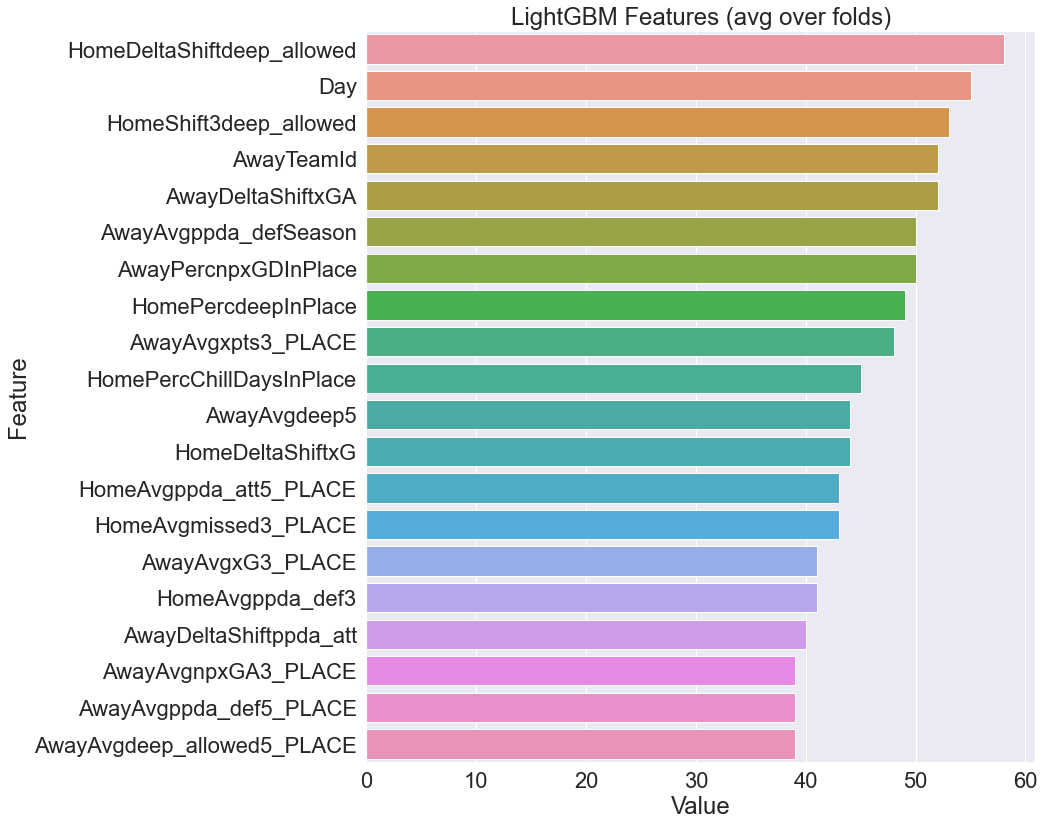

In [190]:
# model.

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':model.feature_name()})

plt.figure(figsize=(15, 12))
# sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

['AwayCumppda_att',
 'AwayAvgloses5',
 'HomeAvgpts5',
 'HomeAvgppda_allowed_defSeason',
 'AwayAvgppda_allowed_def3_PLACE',
 'HomeAvgdeep_allowed3_PLACE',
 'HomeCumppda_allowed_attInPlace',
 'HomeAvgloses3',
 'AwayAvgppda_att3_PLACE',
 'HomeCum1deep_allowed',
 'HomeCum3xpts',
 'AwayAvgscored5',
 'AwayAvgChillDays5_PLACE',
 'AwayCum1wins',
 'AwayCum3xG',
 'AwayShift3draws',
 'AwayCumpts',
 'AwayDeltaCumppda_att',
 'HomeShift2ppda_att',
 'HomeAvglosesSeason',
 'HomeAvgdraws3',
 'HomeAvgChillDays3',
 'HomeAvgxG3',
 'AwayAvgxpts5',
 'HomeCummissedInPlace',
 'HomeAvgnpxGD5',
 'AwayDeltaShiftppda_att',
 'AwayAvgppda_allowed_att5_PLACE',
 'HomeShift2npxGD',
 'HomePercnpxGDInPlace',
 'HomeDeltaShiftppda_att',
 'HomeCum3ppda_att',
 'AwayShift1ppda_def',
 'AwayShift2deep',
 'AwayAvgppda_allowed_attSeason',
 'HomeCumnpxGA',
 'AwayCum2xGA',
 'AwayCumscoredInPlace',
 'HomeDeltaShiftdraws',
 'AwayShift3wins',
 'AwayCum2xpts',
 'AwayAvgwins3',
 'AwayShift1ChillDays',
 'Dayofweek',
 'AwayCum2npxGD',
 '

In [24]:
# 15*15*2
# 30*8
# team equal model = krasnodar - tula
# teams model = krasnodar or tula # 0.923076923076923 0.7070707070707071
# league model = rfpl
# main model = all data


5040

# Парсер OddsPortal.com (selenium+beautySoup)
* если нужно обновить from_file = False

In [3]:
# df_odds, df_bookmakers = Odds(Config).get_last_update_scrapper(df)
odds = OddsParser(Config, last_update=True)
df_odds, df_bookmakers = odds.get_last_update_scrapper(
    df,
    season=2022,
    url='https://www.oddsportal.com/login/',
    username='khaitov',
    password='Kr52301776',
    proxy=False,
    headless=False,
    from_file=True,
)

#### пример простой модели, подаем дату и один таргет

In [14]:
# simple model
run_model = Validation(Config).run_model
# start_date = dt.now()
start_date = pd.to_datetime('2020-02-21').date()
# dt.now()
# pd.to_datetime('2018-12-01').date() # start_date = datetime.datetime.now()
target='2X'

features = list(set(engineering_features + ['HomeTeamId', 'AwayTeamId', 'Season'])-set(['Date']))

df = df[~df.index.duplicated(keep='first')]
df_targets = df_targets[~df_targets.index.duplicated(keep='first')]
y_pred, res, model_tc, oof_pred, all_val_test_index = run_model(
    df=df,
    df_targets=df_targets,
    start_date=start_date,
    target=target,
    features=features,
    val_function=roc_auc_score,
    timeseries=False,
    num_splits=5,
    plot_importances=False,
    exp_target=False,
    verbose=True,
    cv_kfold='lastweek',
    model_name='lightgbm'
)

report_validation(df, df_targets, target, oof_pred, y_pred)


Run model, calc 2X with cv per lastweek
****************************************
2020-02-28
Learn set: 7535 
Target: 2X 
min date:2016-07-30 
max date:2020-02-19 
Weekend set: 45 
min day: 2020-02-21 
max day: 2020-02-24
val train index from 2016-07-30 to 2020-01-15 and shape 7300
val test index from 2020-01-17 to 2020-01-23 and shape 49
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current 

val test index from 2020-02-07 to 2020-02-09 and shape 41
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 4054, number of negative: 3395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

### Прогнозируем все predict_targets из config.py

In [12]:
# start_date = dt.now()
start_date = pd.to_datetime('2020-02-21').date()

# pd.to_datetime('2020-02-21').date()# dt.now()# pd.to_datetime('2018-12-01').date()
features = list(set(engineering_features + ['HomeTeamId', 'AwayTeamId', 'Season'])-set(['Date']))
calc_forecast_on_targets = Validation(Config).calc_forecast_on_targets
df_pred, df_pred_cutoff = calc_forecast_on_targets(
    df=df,#[df['Date']>pd.to_datetime('2018-08-01')], # df,
    df_targets=df_targets,
    features=features,
    start_date=start_date,
    val_function=roc_auc_score,
    num_splits=5,
    plot_importances=False,
    print_report=False,
    verbose=True
)


Run model, calc W with cv per lastweek
****************************************
2020-02-28
Learn set: 7535 
Target: W 
min date:2016-07-30 
max date:2020-02-19 
Weekend set: 45 
min day: 2020-02-21 
max day: 2020-02-24
val train index from 2016-07-30 to 2020-01-15 and shape 7300
val test index from 2020-01-17 to 2020-01-23 and shape 49
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current va

val train index from 2016-07-30 to 2020-02-05 and shape 7449
val test index from 2020-02-07 to 2020-02-09 and shape 41
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 3395, number of negative: 4054
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011342 seconds.
You can set `forc

[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 2158, number of negative: 5142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97349
[LightGBM] [Info] Number of data points in the train set: 7300, number of used features: 619
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97355
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 619
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296116 -> initscore=-0.865863
[LightGBM] [Info] Start training from score -0.865863
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[100]	training's binary_logloss: 0.516625	valid_1's binary_logloss: 0.581943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	training's binary_logloss: 0.517451	valid_1's binary_logloss: 0.514991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Fold: 4  score: 0.7063
val train index from 2016-07-30 to 2020-02-09 and shape 7490
val test index from 2020-02-14 to 2020-02-19 and shape 45
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 5275, number of negative: 2215
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016580 sec


Run model, calc 2X with cv per lastweek
****************************************
2020-02-28
Learn set: 7535 
Target: 2X 
min date:2016-07-30 
max date:2020-02-19 
Weekend set: 45 
min day: 2020-02-21 
max day: 2020-02-24
val train index from 2016-07-30 to 2020-01-15 and shape 7300
val test index from 2020-01-17 to 2020-01-23 and shape 49
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current 

[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 4054, number of negative: 3395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97367
[LightGBM] [Info] Number of data points in 

[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 1835, number of negative: 5465
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97349
[LightGBM] [Info] Number of data points in the train set: 7300, number of used features: 619
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 1877, number of negative: 5613
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97383
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 619
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	training's binary_logloss: 0.650031	valid_1's binary_logloss: 0.651087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's binary_logloss: 0.650849	valid_1's binary_logloss: 0.684986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.672235	valid_1's binary_logloss: 0.67311
Fold: 5  score: 0.614
Weighted score: 0.6397

Run model, calc Total Less 3.5 with cv per lastweek
****************************************

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.547802	valid_1's binary_logloss: 0.425301
Fold: 2  score: 0.902
val train index from 2016-07-30 to 2020-01-29 and shape 7389
val test index from 2020-01-31 to 2020-02-05 and shape 60
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: featur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.542285	valid_1's binary_logloss: 0.591744
Fold: 4  score: 0.6484
val train index from 2016-07-30 to 2020-02-09 and shape 7490
val test index from 2020-02-14 to 2020-02-19 and shape 45
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: featu

val train index from 2016-07-30 to 2020-01-23 and shape 7349
val test index from 2020-01-24 to 2020-01-29 and shape 40
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 5506, number of negative: 1843
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012435 seconds.
You can set `forc

Fold: 2  score: 0.7367
val train index from 2016-07-30 to 2020-01-29 and shape 7389
val test index from 2020-01-31 to 2020-02-05 and shape 60
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 5536, number of negative: 1853
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012909 sec

val train index from 2016-07-30 to 2020-02-05 and shape 7449
val test index from 2020-02-07 to 2020-02-09 and shape 41
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 5581, number of negative: 1868
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013082 seconds.
You can set `forc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.588896	valid_1's binary_loglos

val train index from 2016-07-30 to 2020-02-05 and shape 7449
val test index from 2020-02-07 to 2020-02-09 and shape 41
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] num_threads is set=7, n_jobs=2 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.05 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Info] Number of positive: 3836, number of negative: 3613
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013364 seconds.
You can set `forc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.570594	valid_1's binary_logloss: 0.634152
Fold: 1  score: 0.5341
val train index from 2016-07-30 to 2020-01-23 and shape 7349
val test index from 2020-01-24 to 2020-01-29 and shape 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.589314	valid_1's binary_logloss: 0.618106
Fold: 5  score: 0.5634
Weighted score: 0.6458


### добавляем кэфы, считаем ROI, выбираем лучший вариант по threshold (cutoff), и пороги выставленные в файле config.py

In [7]:
CalcProf = Calculation(Config)

df_roi, df_results = CalcProf.calc_profit(
    df_odds=df_odds,
    df_bookmakers=df_bookmakers,
    df_pred=df_pred,
    df_pred_round=df_pred_cutoff,
    df_targets=df_targets,
    # predict_targets=predict_targets,
    rename=False,#'Interval'
    df=df,
    # info_features=info_features,
    concat_with_info_df=False,
    prev_df_results=False
)

df_odds_interval, df_pred_round_predel = CalcProf.set_optimize_proba_interval(df_odds, df_pred)
df_roi_interval, df_results = CalcProf.calc_profit(
    df_odds=df_odds_interval,
    df_bookmakers=df_bookmakers,
    df_pred=df_pred,
    df_pred_round=df_pred_round_predel,
    df_targets=df_targets,
    # predict_targets=predict_targets,
    rename='Interval',
    df=df,
    # info_features=info_features,
    concat_with_info_df=True,
    prev_df_results=df_results
)

time = str(dt.now().date())
time = time[:4]+'_'+time[5:7]+'_'+time[8:10]
df_results.to_pickle('./Predictions/'+time+' prediction.pkl')
df_results.to_excel('./Predictions/'+time+' prediction.xlsx', index=None)

# print(df_results[['Profit','Interval Profit']].sum())
# print(format(df_results['Interval Profit'].sum()/(df_results['Interval Predict']*100).sum(),'.1%'))

In [8]:
df_results[['HomeTeam', 'AwayTeam', 'Best Roi Bet', 'Coef', 'Proba', 'Best Roi']]

,HomeTeam,AwayTeam,Best Roi Bet,Coef,Proba,Best Roi
IdMatch,,,,,,
14645,Aston Villa,West Ham,Total Less 2.5,2.250,0.492,0.107
14646,Burnley,Manchester City,Total Less 2.5,2.580,0.495,0.276
14647,Fulham,Leicester,L,1.930,0.553,0.068
14650,Wolverhampton Wanderers,Arsenal,L,2.220,0.541,0.201
14651,Manchester United,Southampton,NaN,nan,nan,nan
14652,Newcastle United,Crystal Palace,1X,1.550,0.710,0.100
14653,Tottenham,Chelsea,L,2.360,0.460,0.085
14655,Aston Villa,Arsenal,W,2.960,0.465,0.378
14656,Burnley,Brighton,L,2.660,0.450,0.197


# Рисуем картинки с прогнозом

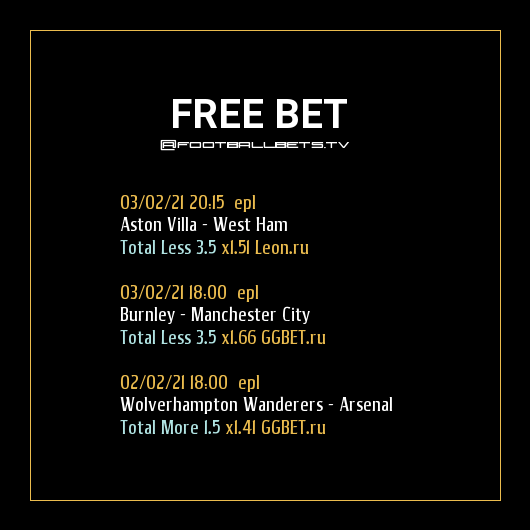

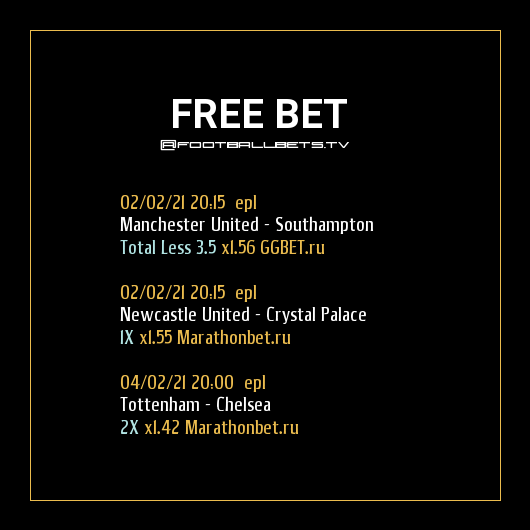

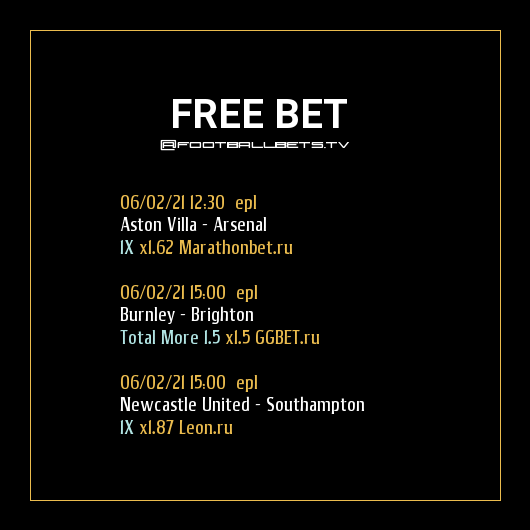

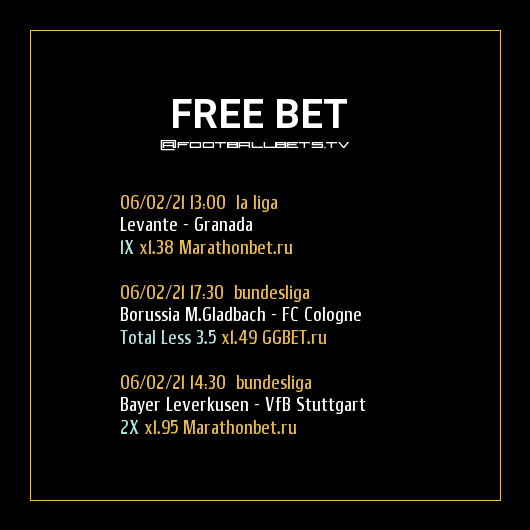

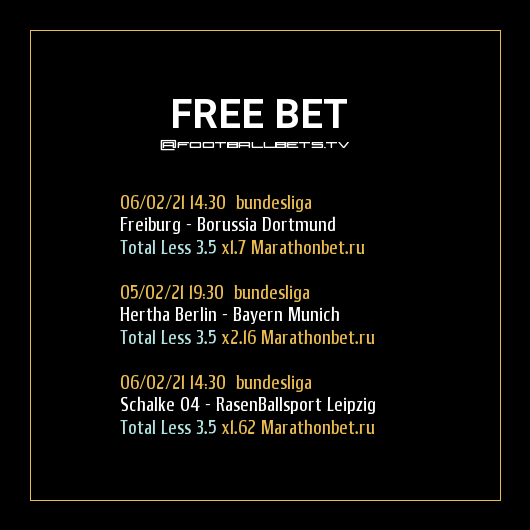

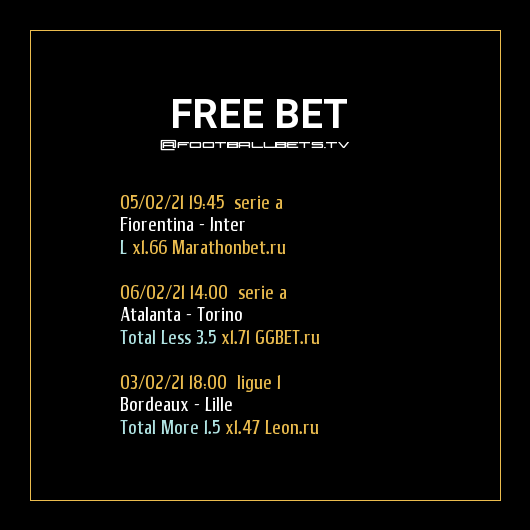

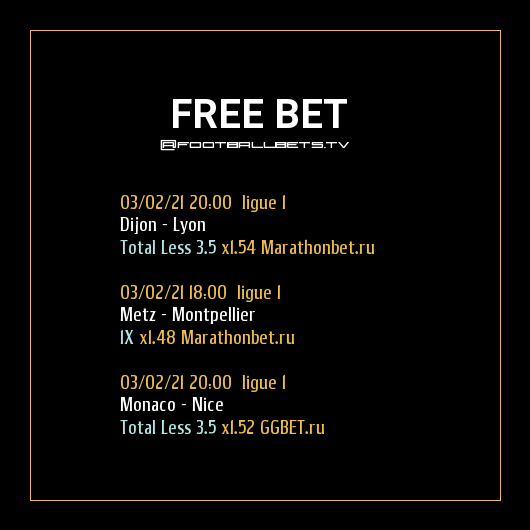

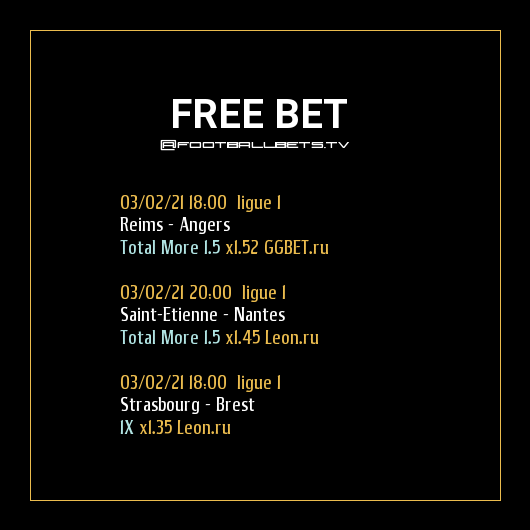

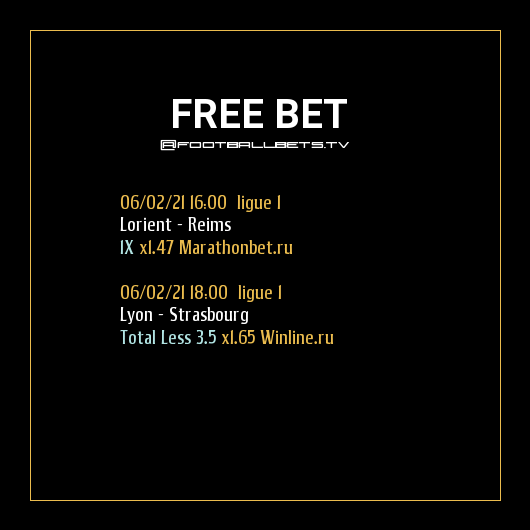

In [9]:
PltPred = PlotPredict(Config)
PltPred.get_plot_predict(
    paint_df=df_results,
    hometeam='HomeTeam',
    awayteam='AwayTeam',
    leaguename='LeagueName',
    bookmaker='Interval Bookmaker',
    bet='Interval Best Roi Bet',
    betcoef='Interval Coef',
    datename='DateTime',
    proba='Interval Proba',
    show_pictures=True,
    clear_pic_path=True,
)

# Выкладываем в instagram
* генерируем хештег из вывески матча
* канал: https://www.instagram.com/footballbets.tv/



- 2020-08-16 21:49:51,387 - INFO - Photo './Pictures/prediction_pics/19_08_20 Ural - Lokomotiv Moscow, FC Ufa - Spartak Moscow, Dinamo Moscow - FC Rostov.jpg' is uploaded.
- ['#Ural', '#Lokomotiv', '#Moscow', '#FC', '#Ufa', '#Spartak', '#Moscow', '#Dinamo', '#Moscow', '#FC', '#Rostov#Football', '#Bets', '#Recommendations', '#stavki']

In [12]:
insta=InstaBot(Config)
insta.login_bot()
while True:
    insta.autoposting(insta.upload_photos, path_medias='./Pictures/prediction_pics/', fromCaptions='File')
    # insta.sleep(100)

2021-02-01 01:11:30,887 - INFO - Instabot version: 0.117.0 Started
2021-02-01 01:11:30,887 - INFO - Instabot version: 0.117.0 Started
2021-02-01 01:11:30,887 - INFO - Instabot version: 0.117.0 Started
2021-02-01 01:11:30,898 - INFO - Recovery from C:\Users\KRN\Documents\GitHub\footkit/config/footballbets.tv_uuid_and_cookie.json: COOKIE True - UUIDs True - TIMING, DEVICE and ...
- user-agent=Instagram 117.0.0.28.123 Android (28/9.0; 420dpi; 1080x1920; OnePlus; ONEPLUS A3003; OnePlus3; qcom; en_US; 180322800)
- phone_id=9194e4e0-c236-4c1d-93fc-399cb5f0f97b
- uuid=6f442454-302d-4358-bacc-52e5886b9c23
- client_session_id=fe19ea7e-bcdc-4b08-9dff-135483c8821f
- device_id=android-09f8dd4cb24ba973
2021-02-01 01:11:30,898 - INFO - Recovery from C:\Users\KRN\Documents\GitHub\footkit/config/footballbets.tv_uuid_and_cookie.json: COOKIE True - UUIDs True - TIMING, DEVICE and ...
- user-agent=Instagram 117.0.0.28.123 Android (28/9.0; 420dpi; 1080x1920; OnePlus; ONEPLUS A3003; OnePlus3; qcom; en_US; 

FOUND: w:530 h:530 r:1.0


2021-02-01 01:11:53,904 - INFO - Photo './Pictures/prediction_pics/02_02_21 Aston Villa - West Ham, Burnley - Manchester City, Wolverhampton Wanderers - Arsenal.jpg' is uploaded.
2021-02-01 01:11:53,904 - INFO - Photo './Pictures/prediction_pics/02_02_21 Aston Villa - West Ham, Burnley - Manchester City, Wolverhampton Wanderers - Arsenal.jpg' is uploaded.
2021-02-01 01:11:53,904 - INFO - Photo './Pictures/prediction_pics/02_02_21 Aston Villa - West Ham, Burnley - Manchester City, Wolverhampton Wanderers - Arsenal.jpg' is uploaded.


 ['#Aston', '#Villa', '#West', '#Ham', '#Burnley', '#Manchester', '#City', '#Wolverhampton', '#Wanderers', '#Arsenal#Football', '#Bets', '#Recommendations', '#stavki']


2021-02-01 01:12:54,189 - ERROR - Request returns 408 error!
2021-02-01 01:12:54,189 - ERROR - Request returns 408 error!
2021-02-01 01:12:54,189 - ERROR - Request returns 408 error!
2021-02-01 01:12:54,193 - ERROR - Error checking for `feedback_required`, response text is not JSON
2021-02-01 01:12:54,193 - ERROR - Error checking for `feedback_required`, response text is not JSON
2021-02-01 01:12:54,193 - ERROR - Error checking for `feedback_required`, response text is not JSON
2021-02-01 01:12:54,195 - INFO - Full Response: <Response [408]>
2021-02-01 01:12:54,195 - INFO - Full Response: <Response [408]>
2021-02-01 01:12:54,195 - INFO - Full Response: <Response [408]>
2021-02-01 01:12:54,197 - INFO - Response Text: 
2021-02-01 01:12:54,197 - INFO - Response Text: 
2021-02-01 01:12:54,197 - INFO - Response Text: 
2021-02-01 01:12:54,199 - ERROR - Error unknown send request
2021-02-01 01:12:54,199 - ERROR - Error unknown send request
2021-02-01 01:12:54,199 - ERROR - Error unknown send 

TypeError: 'NoneType' object is not iterable